# Demo Notebook - Lecture 13

This notebook provides an introduction to explaining the predictions of your neural network model. Building upon last week's fairness lecture, this lecture on explainability is especially relevant to the ethical concerns of modeling human data. Explainable AI aims to answer the question: why did my black box model make prediction y for features x?

To do this, we look at two different classes of AI explainability: global surrogate models (estimating the whole black box) and local surrogate models (explaining one instance's prediction). In this notebook, we will investigate **2 different methods** to explain neural network models:
- Partial Dependency Plots (PDP)
- LIME

The material for this notebook is inspired by a great book on [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/) by Christopher Molnar.

Note that this notebook will need to be run on a kernel with Tensorflow and explainability packages installed. To run the notebook, choose the kernel `Tensorflow` on the top right of Noto.

In [1]:
# Load standard imports for the rest of the notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

DATA_DIR = "./../../data/"

In [2]:
# Load explainability imports.
from lime import lime_tabular
import shap

# Suppress TF warnings during import
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
# Set log level to DEBUG again
tf.get_logger().setLevel('DEBUG')

### Data Preprocessing

We begin by training a model that predicts overall pass / fail performance for students in an EPFL MOOC. 

The input to our model involves features regarding student behavior on a learning platform over 10 weeks. We have seen these features before in lecture 8, when we were using deep knowledge tracing to make predictions on data. The model output is a probability of pass/fail, where 0 is pass and 1 is fail. In the predict functions (predict_fn) for the explainability methods, we flip the model performance, so 1 is pass and 0 is fail.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def train_bidirectional_lstm(features_df: pd.DataFrame,
                             labels_series: pd.Series,
                             num_weeks: int = 10,
                             test_size: float = 0.2,
                             random_state: int = 42,
                             lstm_units: int = 64,
                             dense_units: int = 32,
                             dropout_rate: float = 0.5,
                             learning_rate: float = 1e-3,
                             batch_size: int = 32,
                             epochs: int = 5):

    n_samples, n_features = features_df.shape
    if n_features % num_weeks != 0:
        raise ValueError(f"Expected total features to be divisible by num_weeks={num_weeks}, "
                         f"but got {n_features} total features.")
    n_metrics = n_features // num_weeks

    X = features_df.values.reshape(n_samples, num_weeks, n_metrics)
    y = labels_series.values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    X_train_flat = X_train.reshape(-1, n_metrics)
    X_test_flat  = X_test.reshape(-1,  n_metrics)

    scaler = StandardScaler()
    X_train_flat = scaler.fit_transform(X_train_flat)
    X_test_flat  = scaler.transform(X_test_flat)

    X_train = X_train_flat.reshape(X_train.shape)
    X_test  = X_test_flat.reshape(X_test.shape)

    model = Sequential([
        Bidirectional(
            LSTM(lstm_units, return_sequences=False),
            input_shape=(num_weeks, n_metrics)
        ),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [4]:
features = pd.read_csv('{}/explainability/mooc_features.csv'.format(DATA_DIR))
labels = pd.read_csv('{}/explainability/mooc_labels.csv'.format(DATA_DIR))['0']

In [5]:
loaded_model = train_bidirectional_lstm(features, labels)

Epoch 1/5


/opt/jlab-env-3.12.5/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9016 - loss: 0.2470 - val_accuracy: 0.9719 - val_loss: 0.0847
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9795 - loss: 0.0666 - val_accuracy: 0.9784 - val_loss: 0.0605
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9859 - loss: 0.0462 - val_accuracy: 0.9798 - val_loss: 0.0574
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9790 - loss: 0.0547 - val_accuracy: 0.9798 - val_loss: 0.0563
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9842 - loss: 0.0545 - val_accuracy: 0.9798 - val_loss: 0.0775
Test Loss: 0.0463, Test Accuracy: 0.9879


In [6]:
features.shape, labels.shape

((8679, 250), (8679,))

In [7]:
# For 8,679 students, we have 10 weeks of data with 25 features per week.

display(features)

,RegPeakTimeDayHour_InWeek1,RegPeriodicityM1_InWeek1,DelayLecture_InWeek1,TotalClicks_InWeek1,NumberOfSessions_InWeek1,TotalTimeSessions_InWeek1,AvgTimeSessions_InWeek1,StdTimeBetweenSessions_InWeek1,StdTimeSessions_InWeek1,TotalClicksWeekday_InWeek1,...,TotalTimeVideo_InWeek10,CompetencyAnticipation_InWeek10,ContentAlignment_InWeek10,ContentAnticipation_InWeek10,StudentSpeed_InWeek10,TotalClicksVideoLoad_InWeek10,AvgWatchedWeeklyProp_InWeek10,AvgReplayedWeeklyProp_InWeek10,TotalClicksVideoConati_InWeek10,FrequencyEventLoad_InWeek10
0,3.178054,1.000000e+00,-518326.0,1.0,0.0,0.0,0.000000,0.0,0.000000,1.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
1,7.058606,3.041330e+00,-497116.5,34.0,3.0,5423.0,1807.666667,90701.5,1158.870811,26.0,...,10683.0,0.0,0.8,0.0,558.00,16.0,0.8,0.2,16.0,0.666667
2,5.703059,3.092002e+00,-481356.0,7.0,0.0,0.0,0.000000,0.0,0.000000,7.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
3,6.929695,2.435539e+00,-427158.0,20.0,2.0,4804.0,2402.000000,0.0,998.000000,12.0,...,5325.0,0.0,1.0,0.0,2074.25,16.0,1.0,0.0,16.0,0.301887
4,12.712215,1.000000e+00,-517640.0,4.0,1.0,863.0,863.000000,0.0,0.000000,4.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8674,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
8675,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
8676,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
8677,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000


In [8]:
# For our true labels, we have a pass (0) or fail (1) performance indicator. We only use these labels after obtaining model
# explanations, to try to understand how our model performs against the ground truth.

# There are 8,679 students in this MOOC course.

display(labels)

0       1.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
8674    1.0
8675    1.0
8676    1.0
8677    1.0
8678    1.0
Name: 0, Length: 8679, dtype: float64

# Partial Dependence Plots (PDP)

Partial Dependence plots are global explanations of a certain feature's behavior in the model. In this case, we compare the global performance of a feature (`NumberOfSessions`) from early in the course (Week 2) to late in the course (Week 8).

In [24]:
# We generate the PDP plot against a background distribution of all the points available in the feature set.
# While a minimal background distribution would let us run this analysis faster (i.e. 300 points), we recommend 
# plotting with a much larger point distribution (all the students) if you use this in other situations for 
# improved accuracy and a more global understanding of your model's behavior.

background_distribution = features

In [ ]:
print(loaded_model.input_shape)

In [25]:
# This function converts our data to the right format for the PDP explainer.

predict_fn = lambda x: (1 - loaded_model.predict(x.values.reshape((-1, 10, 25)))).flatten()

272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15

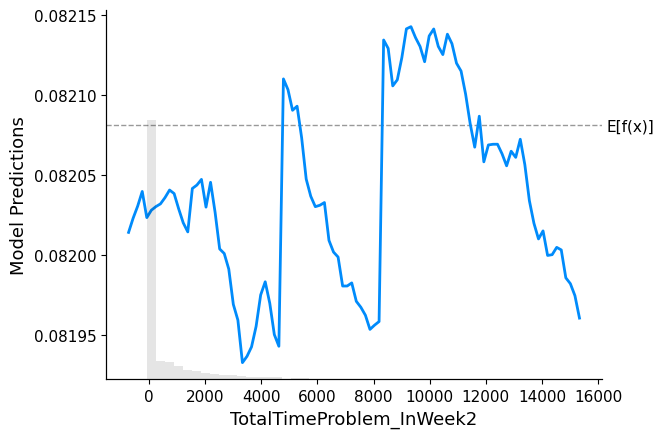

In [15]:
# Let's examine the PDP for TotalTimeProblem_InWeek2.
feat_1 = list(features.columns).index('TotalTimeProblem_InWeek2') 

# Create a partial dependence plot from the background distribution.
fig = shap.plots.partial_dependence(
  feat_1, predict_fn, background_distribution, ice=False, ylabel='Model Predictions',
  model_expected_value=True, feature_expected_value=False, show=True
)

272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 13

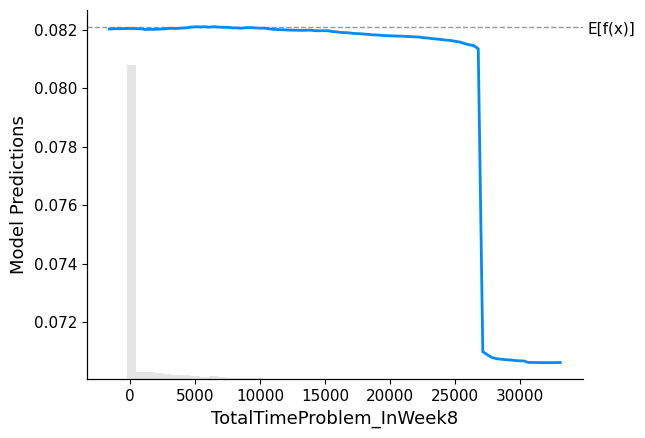

In [26]:
# Let's examine the PDP for TotalTimeProblem_InWeek8.
feat_2 = list(features.columns).index('TotalTimeProblem_InWeek8') 

# Create a partial dependence plot from the background distribution.
fig = shap.plots.partial_dependence(
  feat_2, predict_fn, background_distribution, ice=False, ylabel='Model Predictions',
  model_expected_value=True, feature_expected_value=False, show=True
)

We examine the PDP plots for the `TotalTimeProblem` feature in Week 2 and Week 8, which represents the cumulative time a student spent on problem events in their clickstream. These partial-dependence plots analyze how changing the value of a specific feature impacts the model's predictions.

In the first plot (`TotalTimeProblem` for Week 2), we see two drops in 4000 and 8000 miunutes. The rise from 4000 to 6000 can indicate students which start to have a higher chance of passing the course after they study more, while the later drop might indicate that students spending too much time on problems are struggling with the course and have less of a chance of passing, or have left the tab open and are not actively working on problems. We also note the majority of students have close to 0 time spent on problems in Week 2, although the distribution has a long tail with significant student populations in the first 2000 minutes.

In the second plot (`TotalTimeProblem` for Week 8), we see a consistent model prediction value until between 25000 and 30000 minutes, then we see a drop which can likely again confirm that the students spending too much time on problems are struggling with the course and have less of a chance of passing. Again, the vast majority of students have close to 0 time spent in Week 8 (with a more imbalanced visualization compared to Week 2, possibly due to the students that have already dropped out and the larger numbers of time spent on problems).

# Local Interpretable Model Explanations (LIME)

LIME gives us scores for the most important features for each prediction. We can examine these scores and derive which features of X were important for a particular prediction y.

**Interpreting the LIME Plot:** LIME explanations help us deduce which features were important in the model making this prediction for this specific student, and how much each feature contributed positively or negatively towards the ultimate prediction (scores on the y-axis). The colors indicate how much a feature contributed towards the model prediction in terms of failing (red) or passing (green). The descriptions of the feature names mentioned in recent papers from the lab ([1](https://arxiv.org/abs/2205.01064), [2](https://educationaldatamining.org/EDM2021/virtual/static/pdf/EDM21_paper_202.pdf)) are below.

| **Set**                         | **Feature**       | **Description**                                                                   |
|------------------------------------------|----------------------------|--------------------------------------------------------------------------------------------|
| **Regularity** | DelayLecture               | The average delay in viewing video lectures after they are released to students.           |
|                                      | RegPeakTimeDayHour         | The extent to which students' activities are centered around a particular hour of the day. |
|                                      | RegPeriodicityDayHour      | The extent to which the hourly pattern of user’s activities repeats over days.             |
| **Engagement**                                     | NumberOfSessions           | The number of unique online sessions the student has participated in.                      |
|                                      | RatioClicksWeekendDay      | The ratio between the number of clicks in the weekend and the weekdays                     |
|                                      | AvgTimeSessions            | The average of the student's time per session.                                             |
|                                      | TotalTimeSessions          | The sum of the student's time in sessions.                                                 |
|                                      | StdTimeSessions            | The standard deviation of student's time in sessions.                                      |
|                                      | StdTimeBetweenSessions     | The standard deviation of the time between sessions of each user.                          |
|                                      | TotalClicks                | The number of clicks that a student has made overall.                                      |
|                                      | TotalClicksProblem         | The number of clicks that a student has made on problems this week.                        |
|                                      | TotalClicksVideo           | The number of clicks that a student has made on videos this week.                          |
|                                      | TotalClicksWeekday         | The number of clicks that a student has made on the weekdays.                              |
|                                      | TotalClicksWeekend         | The number of clicks that a student has made on the weekends.                              |
|                                      | TotalTimeProblem           | The total (cumulative) time that a student has spent on problem events.                    |
|                                      | TotalTimeVideo             | The total (cumulative) time that a student has spent on video events.                      |
| **Control**                                     | TotalClicksVideoLoad       | The number of times a student loaded a video.                                              |
|                                      | TotalClicksVideo           | The number of times a student clicked on a video (load, pause, play, forward).             |
|                                      | AvgWatchedWeeklyProp       | The ratio of videos watched over the number of videos available.                           |
|                                      | StdWatchedWeeklyProp       | The standard deviation of videos watched over the number of videos available.              |
|                                      | AvgReplayedWeeklyProp      | The ratio of videos replayed over the number of videos available.                          |
|                                      | StdReplayedWeeklyProp      | The standard deviation of videos replayed over the number of videos available.             |
|                                      | AvgInterruptedWeeklyProp   | The ratio of videos interrupted over the number of videos available.                       |
|                                      | StdInterruptedWeeklyProp   | The standard deviation of videos interrupted over the number of videos available.          |
|                                      | FrequencyEventVideo        | The frequency between every Video action and the following action.                         |
|                                      | FrequencyEventLoad         | The frequency between every Video.Load action and the following action.                    |
|                                      | FrequencyEventPlay         | The frequency between every Video.Play action and the following action.                    |
|                                      | FrequencyEventPause        | The frequency between every Video.Pause action and the following action.                   |
|                                      | FrequencyEventStop         | The frequency between every Video.Stop action and the following action.                    |
|                                      | FrequencyEventSeekBackward | The frequency between every Video.SeekBackward action and the following action.            |
|                                      | FrequencyEventSeekForward  | The frequency between every Video.SeekForward action and the following action.             |
|                                      | FrequencyEventSpeedChange  | The frequency between every Video.SpeedChange action and the following action.             |
|                                      | AvgSeekLength              | The student's average seek length (seconds).                                               |
|                                      | StdSeekLength              | The student's standard deviation for seek length (seconds).                                |
|                                      | AvgPauseDuration           | The student's average pause duration (seconds).                                            |
|                                      | StdPauseDuration           | The student's standard deviation for pause duration (seconds).                             |
|                                      | AvgTimeSpeedingUp          | The student's average time using Video.SeekForward actions (seconds).                      |
|                                      | StdTimeSpeedingUp          | The student's standard deviation of time using Video.SeekForward actions (seconds).        |
| **Participation**                                     | CompetencyStrength         | The extent to which a student passes a quiz getting the maximum grade with few attempts.   |
|                                      | CompetencyAlignment        | The number of problems this week that the student has passed.                              |
|                                      | CompetencyAnticipation     | The extent to which the student approaches a quiz provided in subsequent weeks.            |
|                                      | ContentAlignment           | The number of videos this week that have been watched by the student.                      |
|                                      | ContentAnticipation        | The number of videos covered by the student from those that are in subsequent weeks.       |
|                                      | StudentSpeed               | The average time passed between two consecutive attempts for the same quiz.                |
|                                      | StudentShape               | The extent to which the student receives the maximum quiz grade on the first attempt.      |


In [19]:
# This function returns a (NUM OF INSTANCES, 2) array of probability of pass in first column and 
# probability of failing in another column, which is the format LIME requires.
def predict_fn(x):
    # x is (num_samples, 250)
    x_reshaped = x.reshape((-1, 10, 25))
    preds = loaded_model.predict(x_reshaped)
    # If your model outputs probability of "fail", and you want [pass, fail]:
    return np.hstack([1 - preds, preds])

In [20]:
class_names = ['pass', 'fail']

# We initialize the LIME explainer on our training data.
explainer = lime_tabular.LimeTabularExplainer(
      training_data=np.array(features),
      feature_names=features.columns,
      class_names=class_names,
      mode='classification',
      discretize_continuous=True)

In [21]:
# We choose to explain the behavior of student 1.
instance = 1

# This line calls our LIME explainer on a student instance.
exp_instance = explainer.explain_instance(features.iloc[instance], predict_fn, num_features=10)


/opt/tensorflow/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/tensorflow/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/tensorflow/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


/opt/tensorflow/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/tensorflow/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/tensorflow/lib/python3.12/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Student #:  1
Ground Truth Model Prediction:  1.0 - pass
Black Box Model Prediction:  0.15 - fail


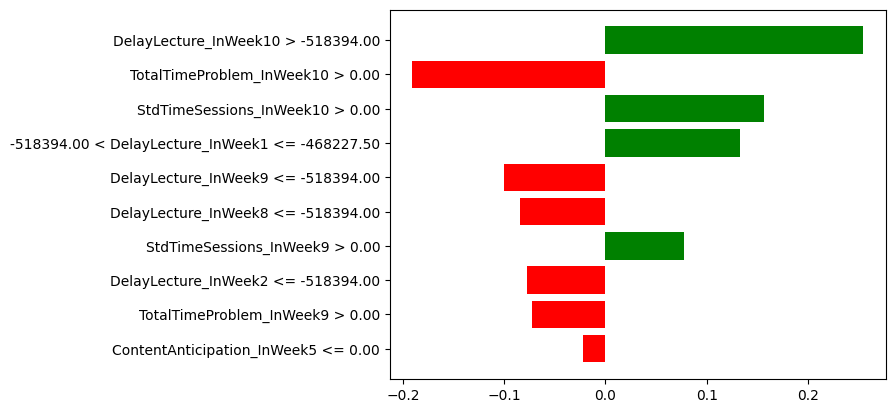

In [23]:
# Let's plot the results. 
def plot_lime(exp):
    s = 'fail' if labels[instance] else 'pass'
    label = exp.available_labels()[0]
    expl = exp.as_list(label=label)
    fig = plt.figure(facecolor='white')
    vals = [x[1] for x in expl]
    names = [x[0] for x in expl]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(expl)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    prediction = loaded_model.predict(np.array(features.iloc[instance]).reshape(1, 10, 25))[0][0]
    prediction = np.round(1-prediction, 2)
    print("Student #: ", instance)
    print("Ground Truth Model Prediction: ", 1-labels[instance], "-", s)
    print("Black Box Model Prediction: ", prediction, "-", 'pass' if prediction > 0.5 else 'fail')
    
plot_lime(exp_instance)

LIME helps identify explanations on the scale of a single point (student). LIME explanations help answer which features were important in the model making this prediction for this specific student, and how much each feature contributed positively or negatively towards the ultimate prediction.

For student 1, we see that the model got the prediction incorrect. The real answer was pass, and the model predicted a fail. Some of the features that were mostly used for this student as passing indicators were their standard deviation of time in sessions (`StdTimeSessions`) and their Delay in watching lecture (`DelayLecture`). The model mostly looks at their performance in later weeks (e.g., week 10).

From this plot, we can make a hypothesis that the student might have had highly variable behavior, contributing to the model predictions. Additionally, we know that later weeks were more important than earlier weeks in this student's prediction. 

The red and green indicate how much a feature contributed towards the model prediction in terms of failing (red) or passing (green). We note TotalTimeProblem in week 10 contributed towards failing, while DelayLecture contributed towards passing.